# Génération du Labyrinthe

> L'objectif de ce notebook est d'entrainer un modèle à générer des labyrinthes complexes et infinis en utilisant les cartes d'exemple disponibles dans ce même répertoire.

## Génération du dataset

Dans un premier temps, nous cherchons à obtenir un dataset de la forme suivante :
$$
\text{Voisinage} \rightarrow \text{Case}
$$
Pour ce faire, nous allons reprendre l'idée des filtres de convolution et balayer le labyrinthe avec un filtre de taille $n\times n$.

In [1]:
# -------------------------- CHARGEMENT DES DONNEES -------------------------- #
import pandas as pd
import os
from IPython.display import display, Markdown

data = {}
for root, dirs, files in os.walk("."):
    for filename in files:
        if filename.endswith(".csv"):
            last_character = filename[-5]
            simple_filename = filename.split(".")[0]
            if simple_filename not in data:
                data[simple_filename] = {}
            if last_character not in data[simple_filename]:
                try:
                    csv = pd.read_csv(filename).to_numpy()
                except:
                    continue
                if csv.shape[0] * csv.shape[1] != 0:
                    data[simple_filename][last_character] = csv

for data_name in data:
    display(Markdown(f"-> **{data_name}** : *{len(data[data_name])} layers*"))

-> **training_map** : *1 layers*

-> **maze** : *1 layers*

In [7]:
# --------------------------- CREATON DES DATASETS --------------------------- #
import numpy as np


def create_dataset(data, window_size=5):
    if data.shape[0] < window_size or data.shape[1] < window_size:
        raise ValueError("Window size is too big for this data")
    dataset = pd.DataFrame(
        [
            data[i : i + window_size, j : j + window_size].flatten()
            for i in range(0, data.shape[0] - window_size + 1)
            for j in range(0, data.shape[1] - window_size + 1)
        ]
    )
    dataset["label"] = dataset[dataset.columns[(window_size**2 - 1) // 2]]
    dataset.drop(dataset.columns[(window_size**2 - 1) // 2], axis=1, inplace=True)

    # Data augmentation with dropouts
    dataset_missing_value = dataset.drop(columns="label").max(axis=1).max() + 1
    dataset_copy = dataset.sample(frac=1)
    mask = dataset_copy.columns != "label"
    dataset_copy_masked = dataset_copy.copy()
    dataset_copy_masked.loc[:, mask] = dataset_copy_masked.loc[:, mask].applymap(
        lambda x: dataset_missing_value if np.random.rand() < 0.5 else x
    )

    dataset = pd.concat(
        [
            dataset,
            dataset_copy_masked,
        ]
    ).drop_duplicates()
    return dataset


datasets = {
    data_name: {
        last_character: create_dataset(data[data_name][last_character])
        for last_character in data[data_name]
    }
    for data_name in data
}
for dataset in datasets:
    for layer in datasets[dataset]:
        display(
            Markdown(
                f"-> **{dataset}** : *{layer} : {len(datasets[dataset][layer])} samples*"
            )
        )

/tmp/ipykernel_10559/2808227340.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_copy_masked.loc[:, mask] = dataset_copy_masked.loc[:, mask].applymap(
/tmp/ipykernel_10559/2808227340.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_copy_masked.loc[:, mask] = dataset_copy_masked.loc[:, mask].applymap(


-> **training_map** : *1 : 24 samples*

-> **maze** : *e : 1300 samples*

In [3]:
# ------------------------------ TRAINING MODELS ----------------------------- #
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    dataset: {
        layer: {
            "model": RandomForestClassifier(verbose=True, n_jobs=-1).fit(
                datasets[dataset][layer].drop("label", axis=1),
                datasets[dataset][layer]["label"],
            ),
            "window_size": int(np.sqrt(datasets[dataset][layer].shape[1])),
            "missing_value": datasets[dataset][layer]
            .drop("label", axis=1)
            .max(axis=1)
            .max()
            + 1,
        }
        for layer in datasets[dataset]
    }
    for dataset in datasets
}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [8]:
# ------------------------------ GENERATING MAZE ----------------------------- #
import numpy as np


def generate_maze(classifier: tuple, size: tuple):
    # Unpack Arguments
    size_x, size_y = size
    window_size = classifier["window_size"]
    missing_value = classifier["missing_value"]
    model = classifier["model"]
    model.set_params(n_jobs=1)

    # Generate Maze
    maze = np.full((size_x + 2 * window_size, size_y + 2 * window_size), missing_value)
    ## Randomly walk through the maze
    for i in range(window_size, size_x + window_size):
        for j in range(window_size, size_y + window_size):
            input = maze[
                i : i + window_size,
                j : j + window_size,
            ].flatten()
            logits = model.predict_proba(
                np.delete(input, (window_size**2 - 1) // 2).reshape(1, -1)
            )[0]
            # Apply temperature to the logits
            logits = logits ** (1 / 0.5)
            # Select random value according to the logits
            maze[i, j] = np.random.choice(model.classes_, p=logits / logits.sum())
    ## Remove the window size
    maze = maze[window_size:-window_size, window_size:-window_size]

    return maze


maze = generate_maze(classifiers["training_map"]["1"], (30, 30))
# Save the maze as a csv file
np.savetxt("maze.csv", maze, delimiter=",", fmt="%d")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

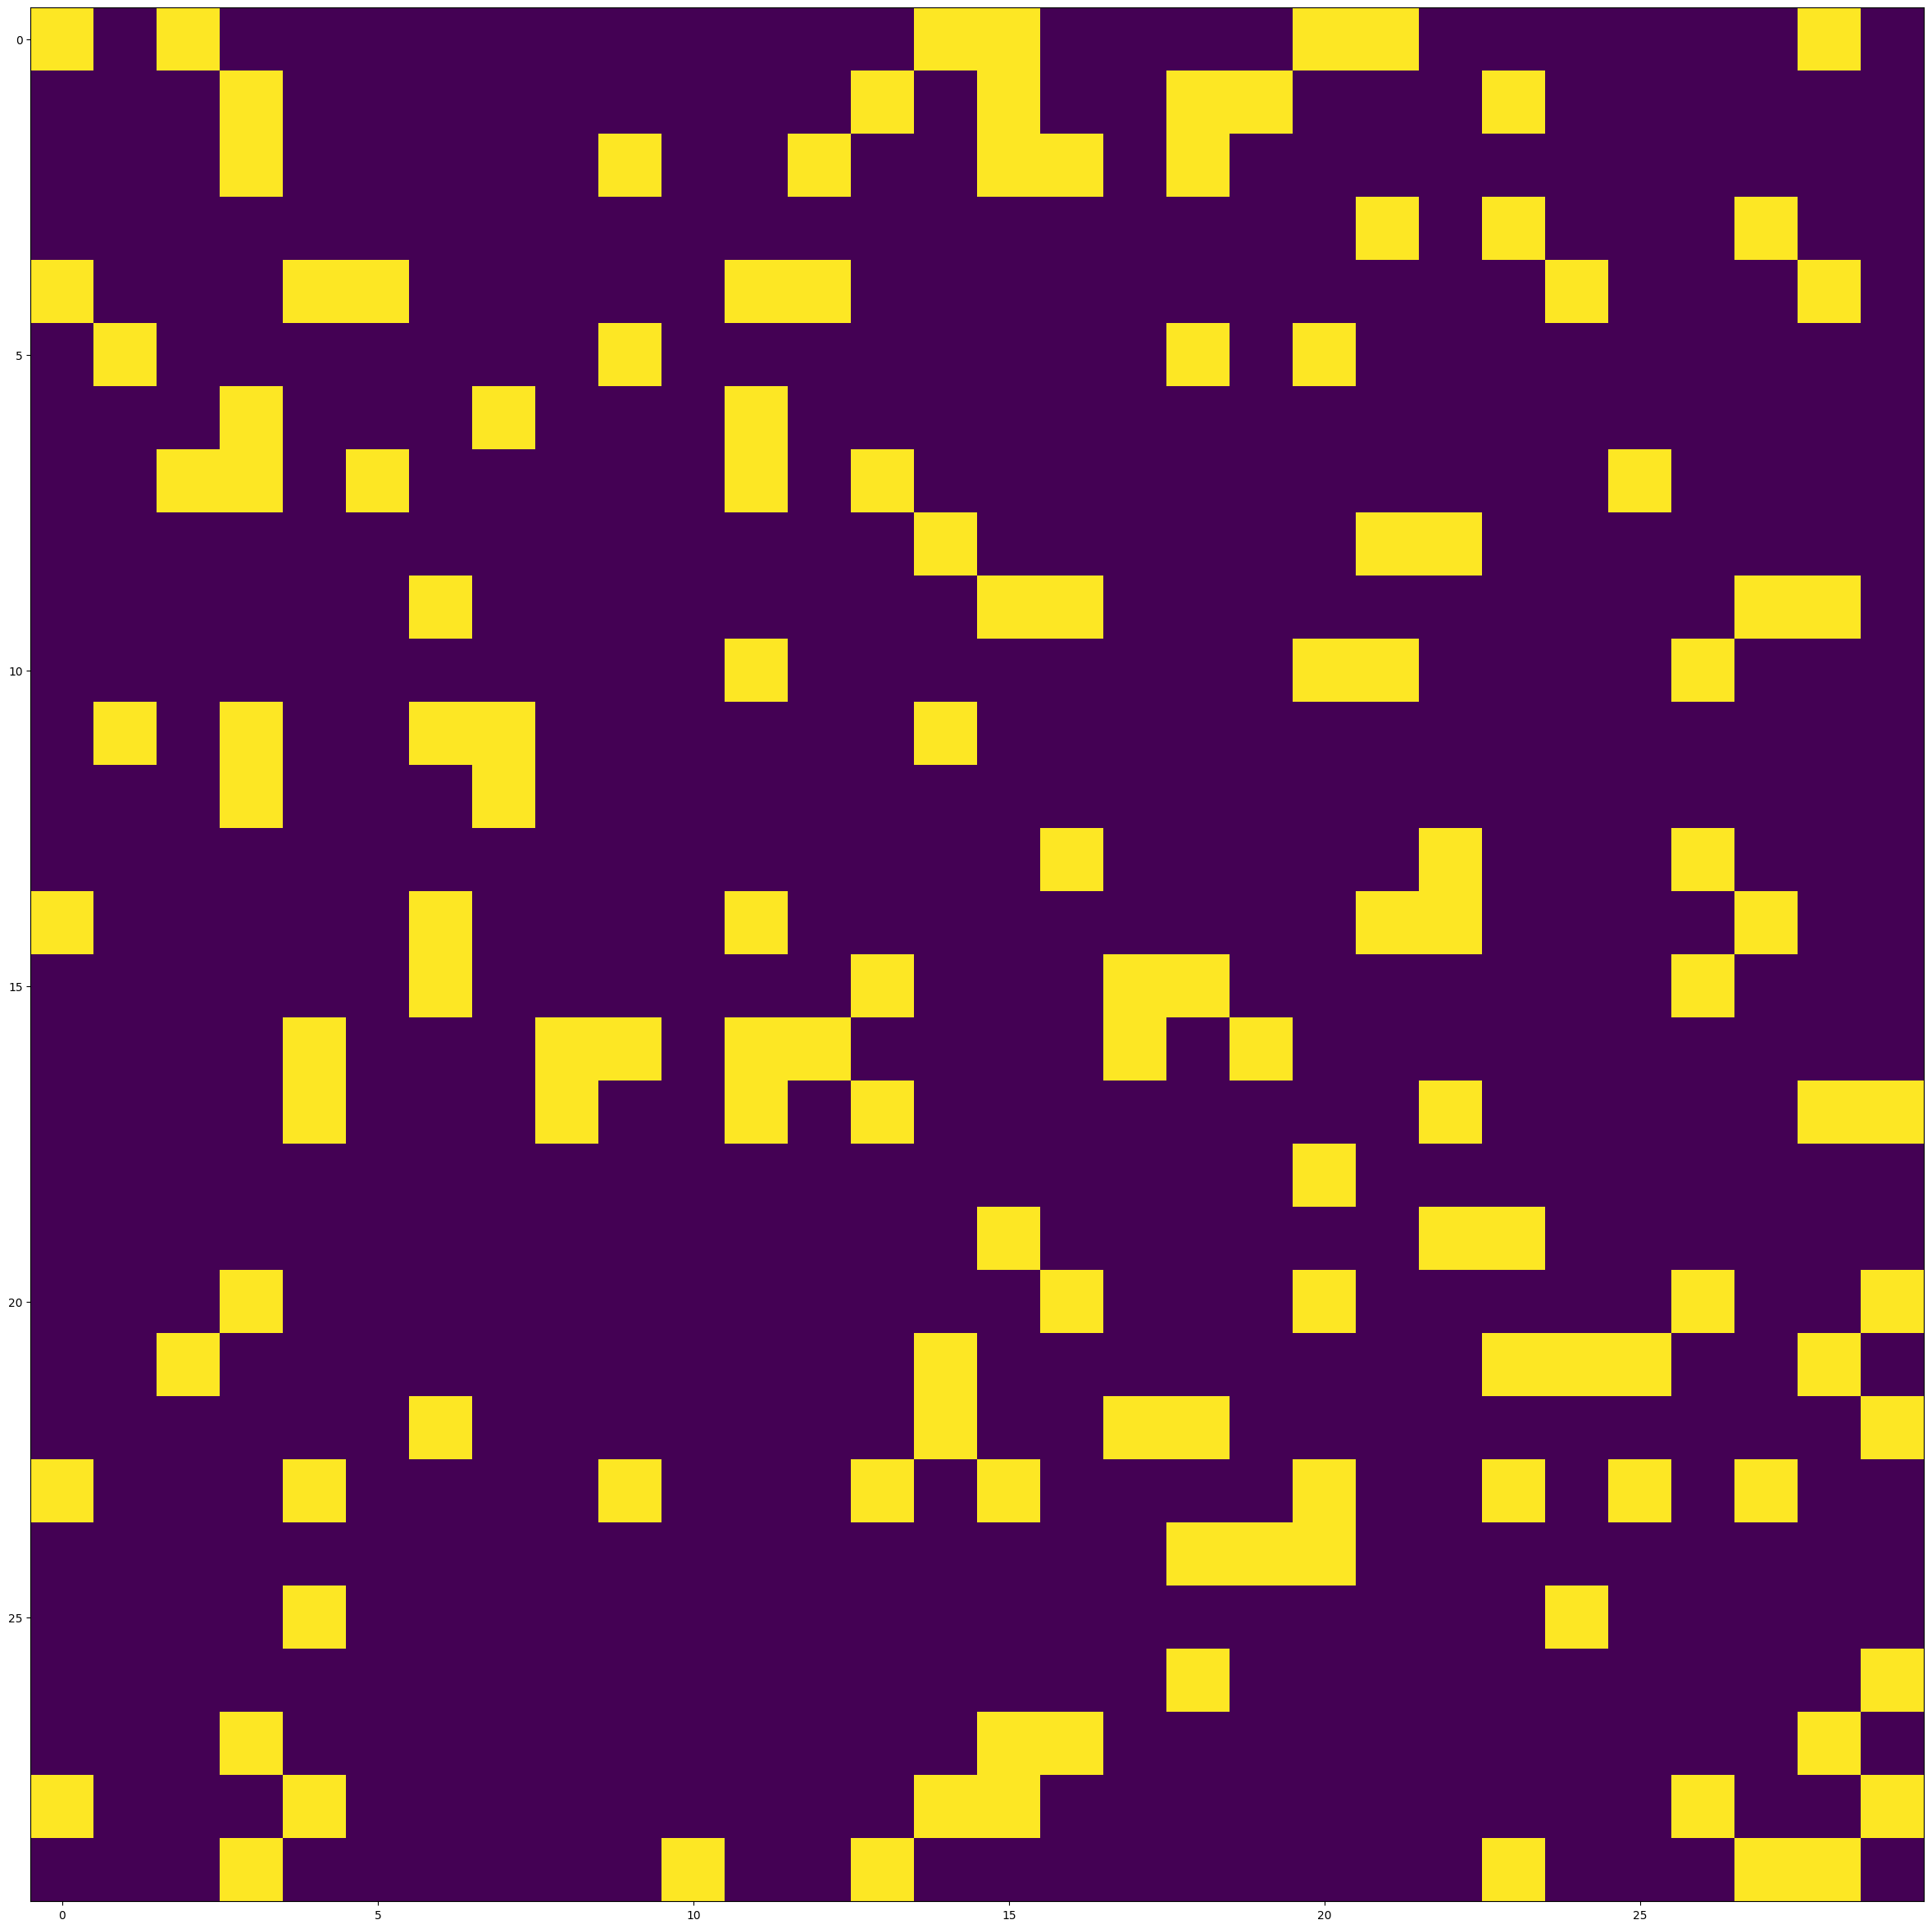

In [9]:
# --------------------------------- PLOT MAP --------------------------------- #
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
plt.imshow(maze)
plt.show()